## Assignment for Module 6

In this assignment you will continue working with the housing price per district from the previous module assignment, this time training SVM models, both for regression and classification.

#### Getting the data for the assignment (similar to the notebook from chapter 2 of Hands-On...)

In [4]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [5]:
fetch_housing_data()

In [6]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [7]:
housing = load_housing_data()

### Fix the categories in the categorical variable

In [8]:
d = {'<1H OCEAN':'LESS_1H_OCEAN', 'INLAND':'INLAND', 'ISLAND':'ISLAND', 'NEAR BAY':'NEAR_BAY', 'NEAR OCEAN':'NEAR_OCEAN'}
housing['ocean_proximity'] = housing['ocean_proximity'].map(lambda s: d[s])

### Add 2 more features

In [9]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["population_per_household"]=housing["population"]/housing["households"]

### Fix missing data

In [10]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True) 

### Create dummy variables based on the categorical variable

In [11]:
one_hot = pd.get_dummies(housing['ocean_proximity'])
housing = housing.drop('ocean_proximity', axis=1)
housing = housing.join(one_hot)

### Check the data

In [12]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 16 columns):
longitude                   20640 non-null float64
latitude                    20640 non-null float64
housing_median_age          20640 non-null float64
total_rooms                 20640 non-null float64
total_bedrooms              20640 non-null float64
population                  20640 non-null float64
households                  20640 non-null float64
median_income               20640 non-null float64
median_house_value          20640 non-null float64
rooms_per_household         20640 non-null float64
population_per_household    20640 non-null float64
INLAND                      20640 non-null uint8
ISLAND                      20640 non-null uint8
LESS_1H_OCEAN               20640 non-null uint8
NEAR_BAY                    20640 non-null uint8
NEAR_OCEAN                  20640 non-null uint8
dtypes: float64(11), uint8(5)
memory usage: 1.8 MB


### Partition into train and test

Use train_test_split from sklearn.model_selection to partition the dataset into 70% for training and 30% for testing.

You can use the 70% for training set as both training and validation by using cross-validation.


In [13]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.3, random_state=42)

### Features

In [14]:
target = 'median_house_value'
features = list(train_set.columns)
features = [f for f in features if f!=target]

In [15]:
X_tr = train_set[features]
y_tr = train_set[[target]]

X_te = test_set[features]
y_te = test_set[[target]]

### Scaling features

Similarly, use StandardScaler from sklearn.preprocessing to normalize the training and testing data, using the training data

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

#### Comparing models

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())

### Linear regression on original features (no transformations) --- benchmark

In [18]:
from sklearn.linear_model import LinearRegression
lin_scores = cross_val_score(LinearRegression(), train_set[features], train_set[target], scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 70142.55721218  67456.39127204  67318.3258893   70866.26065275]
Mean: 68945.8837566


### 1. Support Vector Machines for Regression

#### (a) In this exercise your goal is to tune SVR with FBR kernel, and make the average score mean_squared_error over 3-folds (cv=3) below 58000. 

You are encouraged to try optimizing any of the hyper-parameters of SVR

See http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html for more details

However, as a hint, you can focus on C and gamma. 

Hint 2: if when you try different values for a hyper-parameter, the optimal models corresponds to one of the extreme values in your range, that probably means you can keep improving your solution by considering values beyond the current range.



In [128]:
from sklearn.svm import SVR

C_vals = [40000,45000,50000,55000,60000,65000,70000] ## YOUR VALUES FOR C ##
gamma_vals = [0.0525,0.0530,0.0535,0.0540,0.0545] ## YOUR VALUES FOR gamma ## 

#use verbose=3 to see model progress and scores
param_grid_rbf = [{'C':C_vals, 'gamma':gamma_vals}]
grid_search_rbf = GridSearchCV(SVR(kernel='rbf'), param_grid_rbf, cv=3,verbose=3,scoring='neg_mean_squared_error')
grid_search_rbf.fit(X_tr, np.ravel(y_tr))

Fitting 3 folds for each of 35 candidates, totalling 105 fits
[CV] C=40000, gamma=0.0525 ...........................................
[CV] .. C=40000, gamma=0.0525, score=-3621965290.109213, total=   8.0s
[CV] C=40000, gamma=0.0525 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s remaining:    0.0s


[CV] .. C=40000, gamma=0.0525, score=-3469581685.289202, total=   8.4s
[CV] C=40000, gamma=0.0525 ...........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   24.4s remaining:    0.0s


[CV] .. C=40000, gamma=0.0525, score=-3719586201.520208, total=   7.9s
[CV] C=40000, gamma=0.053 ............................................
[CV] ... C=40000, gamma=0.053, score=-3618952579.266771, total=   6.1s
[CV] C=40000, gamma=0.053 ............................................
[CV] ... C=40000, gamma=0.053, score=-3467334361.740825, total=   6.2s
[CV] C=40000, gamma=0.053 ............................................
[CV] ... C=40000, gamma=0.053, score=-3716968735.994022, total=   6.5s
[CV] C=40000, gamma=0.0535 ...........................................
[CV] .. C=40000, gamma=0.0535, score=-3615307702.400349, total=   5.9s
[CV] C=40000, gamma=0.0535 ...........................................
[CV] .. C=40000, gamma=0.0535, score=-3465403860.150068, total=   6.0s
[CV] C=40000, gamma=0.0535 ...........................................
[CV] .. C=40000, gamma=0.0535, score=-3714444153.837089, total=   5.9s
[CV] C=40000, gamma=0.054 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed: 16.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [40000, 45000, 50000, 55000, 60000, 65000, 70000], 'gamma': [0.0525, 0.053, 0.0535, 0.054, 0.0545]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=3)

In [129]:
print(grid_search_rbf.best_params_)
print(np.sqrt(-grid_search_rbf.best_score_))

{'C': 70000, 'gamma': 0.0545}
59055.9051765


In [130]:
from sklearn.svm import SVR

C_vals = [140000,145000,150000] ## YOUR VALUES FOR C ##
gamma_vals = [0.058,0.6,0.7] ## YOUR VALUES FOR gamma ## 

#use verbose=3 to see model progress and scores
param_grid_rbf = [{'C':C_vals, 'gamma':gamma_vals}]
grid_search_rbf = GridSearchCV(SVR(kernel='rbf'), param_grid_rbf, cv=3,verbose=3,scoring='neg_mean_squared_error')
grid_search_rbf.fit(X_tr, np.ravel(y_tr))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] C=140000, gamma=0.058 ...........................................
[CV] .. C=140000, gamma=0.058, score=-3358564651.413456, total=   6.9s
[CV] C=140000, gamma=0.058 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s


[CV] .. C=140000, gamma=0.058, score=-3220592296.831881, total=   6.7s
[CV] C=140000, gamma=0.058 ...........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.2s remaining:    0.0s


[CV] .. C=140000, gamma=0.058, score=-3485009394.334552, total=   6.8s
[CV] C=140000, gamma=0.6 .............................................
[CV] .... C=140000, gamma=0.6, score=-3334068503.167843, total=  19.1s
[CV] C=140000, gamma=0.6 .............................................
[CV] .... C=140000, gamma=0.6, score=-3188709698.179639, total=  17.8s
[CV] C=140000, gamma=0.6 .............................................
[CV] .... C=140000, gamma=0.6, score=-3372406025.769373, total=  21.4s
[CV] C=140000, gamma=0.7 .............................................
[CV] .... C=140000, gamma=0.7, score=-3413302468.757632, total=  22.4s
[CV] C=140000, gamma=0.7 .............................................
[CV] .... C=140000, gamma=0.7, score=-3266960091.804371, total=  26.4s
[CV] C=140000, gamma=0.7 .............................................
[CV] .... C=140000, gamma=0.7, score=-3443330800.536984, total=  20.1s
[CV] C=145000, gamma=0.058 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  8.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [140000, 145000, 150000], 'gamma': [0.058, 0.6, 0.7]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=3)

In [131]:
print(grid_search_rbf.best_params_)
print(np.sqrt(-grid_search_rbf.best_score_))

{'C': 150000, 'gamma': 0.6}
57357.5655643


### Performance on Test Set

In [132]:
from sklearn.metrics import mean_squared_error

final_model = grid_search_rbf.best_estimator_   ## THIS SHOULD BE THE BEST GRID_SEARCH ##

y_te_estimation = final_model.predict(X_te)

final_mse = mean_squared_error(y_te, y_te_estimation)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

54952.9545466


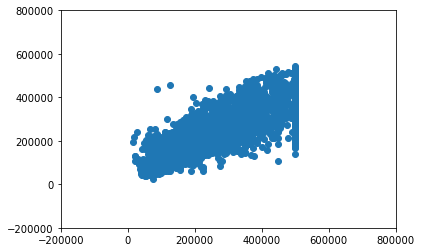

In [133]:
import matplotlib.pyplot as plt

plt.scatter(x=y_te, y=y_te_estimation)
plt.xlim([-200000,800000])
plt.ylim([-200000,800000])
plt.show()

### 2. SVM for Classification

Now we transform the continuous target into a binary variable, indicating whether or not the price is above the average $179700


In [19]:
from sklearn.metrics import accuracy_score

In [20]:
np.median(housing[['median_house_value']])

179700.0

#### Binary target variable

In [21]:
y_tr_b = 1*np.ravel(y_tr>=179700.0)
y_te_b = 1*np.ravel(y_te>=179700.0)

#### Linear SVM for classification

In [22]:
from sklearn.svm import LinearSVC

In [23]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_tr, y_tr_b)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [24]:
y_pred = lin_clf.predict(X_tr)
accuracy_score(y_tr_b, y_pred)

0.83845514950166111

### (a) Does SVC (with default hyper-parameters) improve the performance of the linear SVM?

Yes! The accuracy improves by about 3%.

In [25]:
from sklearn.svm import SVC

In [26]:
# SVC rbd model
svm_clf = SVC(random_state=42, kernel='rbf',verbose=10)
svm_clf.fit(X_tr, y_tr_b)
y_pred = svm_clf.predict(X_tr)
print(svm_clf.get_params)
accuracy_score(y_tr_b, y_pred)

[LibSVM]<bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=10)>


0.86614064230343302

In [27]:
# SVC polynomial model
svm_clf = SVC(random_state=42,kernel='poly', verbose=10)
svm_clf.fit(X_tr, y_tr_b)
y_pred = svm_clf.predict(X_tr)
print(svm_clf.get_params)
accuracy_score(y_tr_b, y_pred)

[LibSVM]<bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=10)>


0.85215946843853818

### (b) Use randomized search to tune hyper-parameters of SVC and improve its performance

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
from scipy.stats import randint as sp_randint

In [29]:
#use verbose=3 to see model progress and scores
param_dists = {'C':uniform(0.0001,20),'gamma':uniform}

n_iter_search = 10

rand_grid_search = RandomizedSearchCV(SVC(),
                                      param_distributions=param_dists,
                                      cv=2,
                                      verbose=3,
                                      n_iter=n_iter_search)

rand_grid_search.fit(X_tr, y_tr_b)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] C=7.79331215407, gamma=0.635143514433 ...........................
[CV]  C=7.79331215407, gamma=0.635143514433, score=0.855917, total=   2.3s
[CV] C=7.79331215407, gamma=0.635143514433 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV]  C=7.79331215407, gamma=0.635143514433, score=0.851585, total=   2.1s
[CV] C=1.57201976455, gamma=0.44856843366 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


[CV]  C=1.57201976455, gamma=0.44856843366, score=0.864221, total=   1.9s
[CV] C=1.57201976455, gamma=0.44856843366 ............................
[CV]  C=1.57201976455, gamma=0.44856843366, score=0.857123, total=   1.9s
[CV] C=4.31184580184, gamma=0.431243817008 ...........................
[CV]  C=4.31184580184, gamma=0.431243817008, score=0.866298, total=   1.9s
[CV] C=4.31184580184, gamma=0.431243817008 ...........................
[CV]  C=4.31184580184, gamma=0.431243817008, score=0.857538, total=   2.0s
[CV] C=7.74714123589, gamma=0.274284567704 ...........................
[CV]  C=7.74714123589, gamma=0.274284567704, score=0.868789, total=   2.4s
[CV] C=7.74714123589, gamma=0.274284567704 ...........................
[CV]  C=7.74714123589, gamma=0.274284567704, score=0.859477, total=   1.9s
[CV] C=18.2790808955, gamma=0.453337644397 ...........................
[CV]  C=18.2790808955, gamma=0.453337644397, score=0.856886, total=   2.3s
[CV] C=18.2790808955, gamma=0.453337644397 ........

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   56.0s finished


RandomizedSearchCV(cv=2, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000AA83358>, 'gamma': <scipy.stats._continuous_distns.uniform_gen object at 0x000000000A3481D0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=3)

In [31]:
print(rand_grid_search.best_params_)
print(rand_grid_search.best_score_)

{'C': 14.608209777187829, 'gamma': 0.30452421805491559}
0.865102436323


# Conclusion:

Randomized search didn't seem to produce better results than the default parameters. However I can see how this would be useful for developing a model with many parameters as it gives you a good place to start, and you can then move to gridseachCV for more targeted fine tuning. 